In [13]:
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import math

sc.set_figure_params(dpi=100, frameon=False, facecolor=None, transparent=True, figsize=(5,5))

In [14]:
zebrafish = sc.read('/lustre/groups/ml01/workspace/alejandro.tejada/COLE/fullDataZebra.h5ad')

In [16]:
zebrafish

AnnData object with n_obs × n_vars = 2758961 × 32031
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [17]:
zebrafish.obs.gene_target

A03_B01_P01-A01_LIG104     ctrl-inj
A03_B01_P01-A02_LIG101     ctrl-inj
A03_B01_P01-A02_LIG127     ctrl-inj
A03_B01_P01-A02_LIG257    ctrl-noto
A03_B01_P01-A03_LIG201    ctrl-noto
                            ...    
H07_D12_P04-H12_LIG258    mafba-mut
H07_D12_P04-H12_LIG264       tfap2a
H07_D12_P04-H12_LIG302    mafba-mut
H07_D12_P04-H12_LIG370        foxd3
H07_D12_P04-H12_LIG6         tfap2a
Name: gene_target, Length: 2758961, dtype: category
Categories (35, object): ['cdx4', 'cdx4-cdx1a', 'ctrl-hgfa', 'ctrl-inj', ..., 'tfap2a', 'tfap2a-foxd3', 'wnt3a-wnt8', 'zc4h2']

In [5]:
zebrafish.var[zebrafish.var.gene_short_name.isin(['smo', 'foxd3', 'tfap2a', 'mafba', 'wnt8a'])]

,gene_short_name,id,chromosome,bp1,bp2,gene_strand,num_cells_expressed
ENSDARG00000002952,smo,ENSDARG00000002952,4,14971239,14980437,+,conf
ENSDARG00000017121,mafba,ENSDARG00000017121,23,3405165,3409140,-,conf
ENSDARG00000021032,foxd3,ENSDARG00000021032,6,32091532,32093830,-,conf
ENSDARG00000052910,wnt8a,ENSDARG00000052910,14,34490445,34495215,+,conf
ENSDARG00000059279,tfap2a,ENSDARG00000059279,24,8721176,8732519,-,conf
ENSDARG00000078507,wnt8a,ENSDARG00000078507,14,34495216,34498224,+,conf


In [6]:
zebrafish.obs.cell_type_sub.value_counts()

cell_type_sub
periderm 10                                    166572
mature fast muscle 6                            99948
connective tissue-meninges-dermal FB (late)     84413
mature fast muscle 2                            77466
periderm 14                                     75727
                                                ...  
enveloping layer (EVL)                             46
periderm 15                                        22
intestine (late)                                   18
mineralized tissue, bone                            7
lens (other)                                        1
Name: count, Length: 151, dtype: int64

In [7]:
zebrafish.obs.gene_target.value_counts()

gene_target
ctrl-inj        362755
tfap2a          159388
tfap2a-foxd3    127151
epha4a          124704
egr2b           118306
foxd3           116702
ctrl-hgfa       116548
hgfa-mut        104690
noto-mut         87586
tbx1             87472
mafba-mut        84482
foxi1            81688
mafba            76095
zc4h2            73288
hand2            72216
egr2b-remove     71826
hoxb1a           71298
phox2a           71102
met-mut          66147
tbx16            61804
tbx16-msgn1      60289
tbx16-tbx16l     58023
noto             57847
smo              57625
cdx4             57611
ctrl-noto        49172
cdx4-cdx1a       48277
hgfa             44929
tbxta            39680
ctrl-met         38406
ctrl-mafba       34954
wnt3a-wnt8       34686
met              25735
ctrl-tbx16        9004
tbx16-mut         7475
Name: count, dtype: int64

It's weird, but after reading the paper and talking to the experimentalist, **explanation below:**

ctrl-inj is control. gene-mut denotes zebrafish born with a mutation in the gene (vs. F0 CRISPR-Cas9), and ctrl-gene is a fish with similar genetic background as gene-mut but without the mutation. gene indicates a knock out for that gene using F0 CRISPR, and two genes such as tbx16-msgn1 indicate a double gene KO.

We will treat all gene and gene-mut as the same phenotype as they were remarked to be similar in Saunders et al, and all ctrl-gene will be treated as control

In [18]:
def mapping(label):
    if label == 'ctrl-inj':
        ret = 'negative'
    elif 'ctrl' in label:
        ret = 'negative'
    elif 'mut' in label or 'remove' in label:
        ret = label.split('-')[0]
    elif '-' in label:
        return label.split('-')[0], label.split('-')[1]
    else:
        return label, 'negative'
    return ret, 'negative'

In [19]:
zebrafish.obs['gene1+gene2'] = [f'{mapping(x)[0]}+{mapping(x)[1]}' for x in zebrafish.obs.gene_target]

In [20]:
zebrafish.obs.loc[zebrafish.obs['gene1+gene2'] == 'wnt8a+negative']

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,group_cluster,gene_target,mean_nn_time,subumap3d_1,subumap3d_2,subumap3d_3,sample,hash_plate,log.hash_umis,gene1+gene2


In [10]:
zebrafish.obs['gene1+gene2'].value_counts()

gene1+gene2
negative+negative    610839
egr2b+negative       190132
mafba+negative       160577
tfap2a+negative      159388
hgfa+negative        149619
noto+negative        145433
tfap2a+foxd3         127151
epha4a+negative      124704
foxd3+negative       116702
met+negative          91882
tbx1+negative         87472
foxi1+negative        81688
zc4h2+negative        73288
hand2+negative        72216
hoxb1a+negative       71298
phox2a+negative       71102
tbx16+negative        69279
tbx16+msgn1           60289
tbx16+tbx16l          58023
smo+negative          57625
cdx4+negative         57611
cdx4+cdx1a            48277
tbxta+negative        39680
wnt3a+wnt8            34686
Name: count, dtype: int64

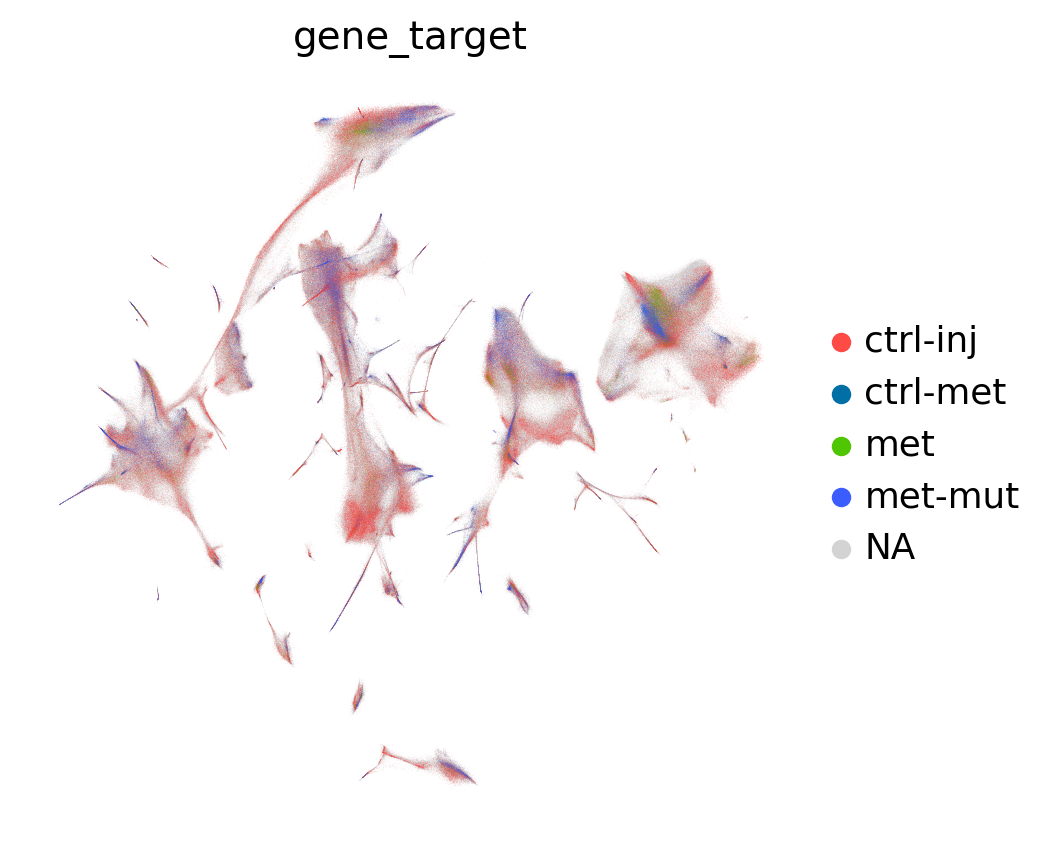

In [11]:
sc.pl.umap(zebrafish, color='gene_target', groups=['ctrl-inj', 'met', 'ctrl-met', 'met-mut'])

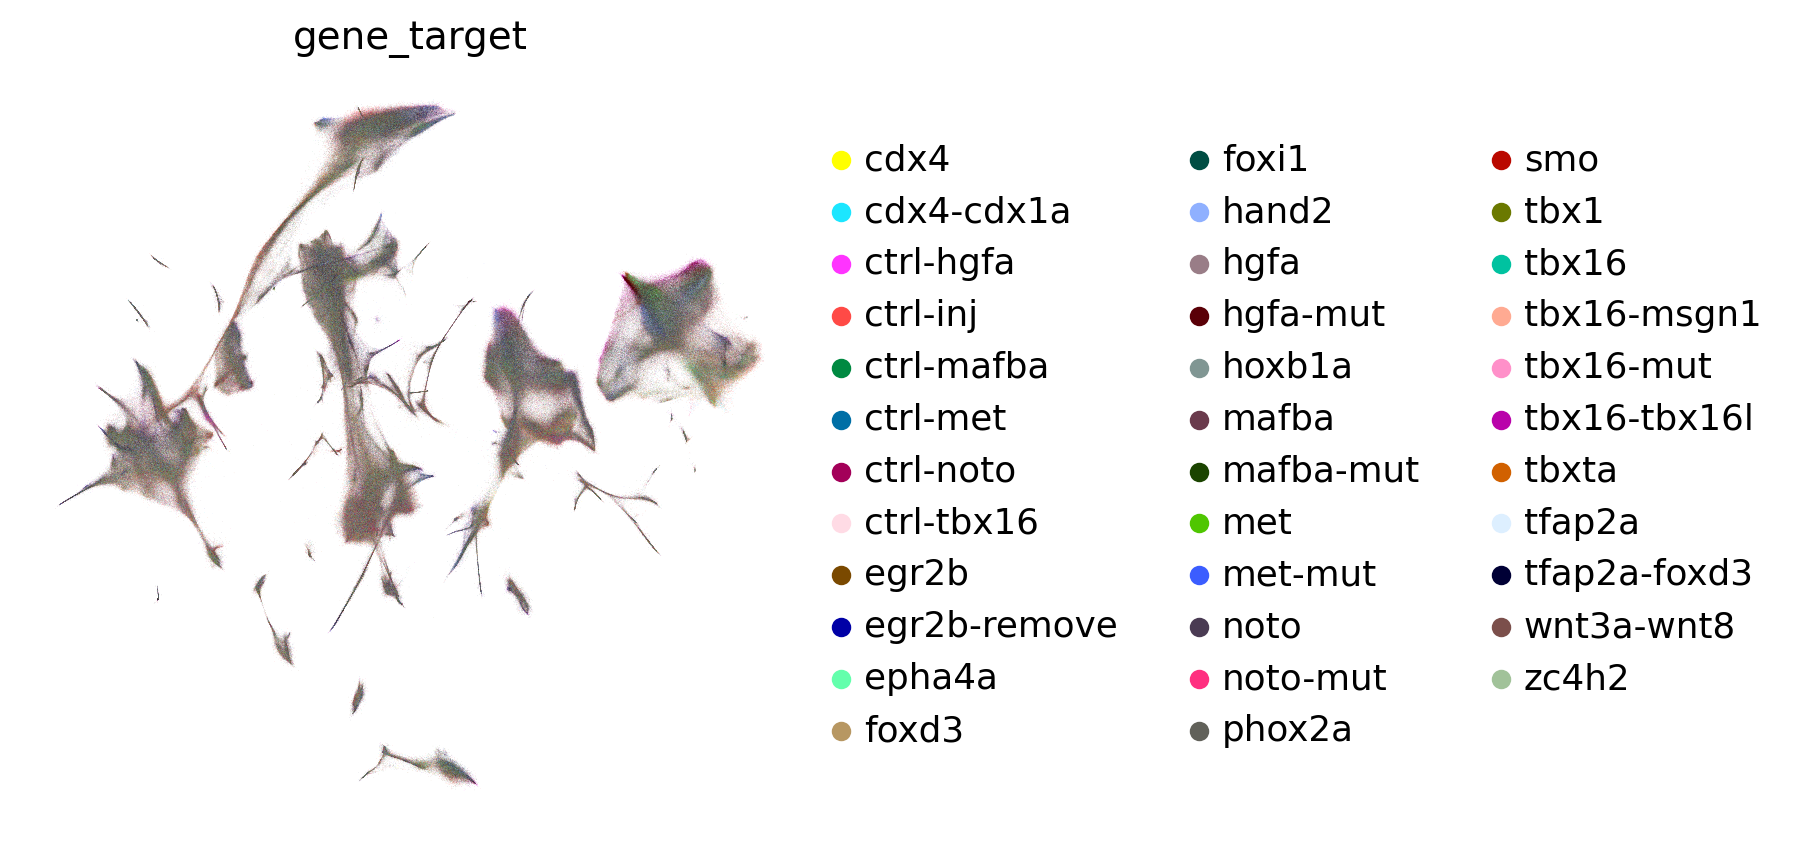

In [12]:
sc.pl.umap(zebrafish, color=['gene_target'])

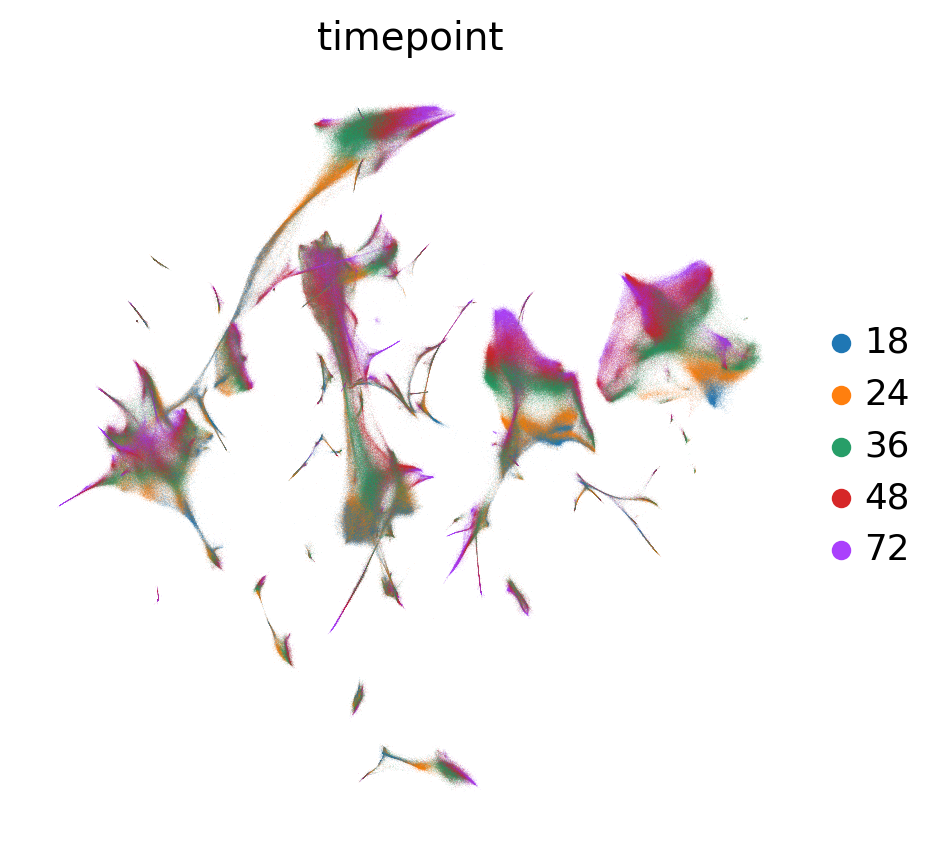

In [13]:
sc.pl.umap(zebrafish, color=['timepoint'])

The .X already contains count data.

In [14]:
sc.pp.normalize_total(zebrafish)
sc.pp.log1p(zebrafish)

In [15]:
sc.pp.highly_variable_genes(zebrafish, inplace=True, n_top_genes=2000)

In [16]:
zebrafish = zebrafish[:,zebrafish.var["highly_variable"]==True]

In [17]:
zebrafish

View of AnnData object with n_obs × n_vars = 2758961 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [18]:
zebrafish

View of AnnData object with n_obs × n_vars = 2758961 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [19]:
zebrafish.obs['gene1+gene2']

A03_B01_P01-A01_LIG104    negative+negative
A03_B01_P01-A02_LIG101    negative+negative
A03_B01_P01-A02_LIG127    negative+negative
A03_B01_P01-A02_LIG257    negative+negative
A03_B01_P01-A03_LIG201    negative+negative
                                ...        
H07_D12_P04-H12_LIG258       mafba+negative
H07_D12_P04-H12_LIG264      tfap2a+negative
H07_D12_P04-H12_LIG302       mafba+negative
H07_D12_P04-H12_LIG370       foxd3+negative
H07_D12_P04-H12_LIG6        tfap2a+negative
Name: gene1+gene2, Length: 2758961, dtype: category
Categories (24, object): ['cdx4+cdx1a', 'cdx4+negative', 'egr2b+negative', 'epha4a+negative', ..., 'tfap2a+foxd3', 'tfap2a+negative', 'wnt3a+wnt8', 'zc4h2+negative']

In [20]:
zebrafish.obs[['gene1', 'gene2']] = zebrafish.obs['gene1+gene2'].str.split('+', expand=True)


/tmp/ipykernel_2798923/2187450260.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  zebrafish.obs[['gene1', 'gene2']] = zebrafish.obs['gene1+gene2'].str.split('+', expand=True)


In [21]:
zebrafish.obs

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,mean_nn_time,subumap3d_1,subumap3d_2,subumap3d_3,sample,hash_plate,log.hash_umis,gene1+gene2,gene1,gene2
A03_B01_P01-A01_LIG104,A03_B01_P01-A01_LIG104,0.766072,348.0,4.022989,18,18h_ctrl-inj_P13_H1,29.0,25.803177,head mesenchyme/PA cartilage,head mesenchyme/PA cartilage,...,22.000000,4.793726,-1.605781,-4.725532,1,NA,NaN,negative+negative,negative,negative
A03_B01_P01-A02_LIG101,A03_B01_P01-A02_LIG101,1.001617,455.0,9.010989,72,72h_ctrl-inj_P10_A6,46.0,5.384193,intestine (mid),intestine,...,72.000000,-8.592424,4.106266,1.090345,1,NA,NaN,negative+negative,negative,negative
A03_B01_P01-A02_LIG127,A03_B01_P01-A02_LIG127,2.007637,912.0,1.644737,36,36h_ctrl-inj_P7_A8,15.0,9.082616,basal cell (early),basal cell,...,44.266667,2.031515,0.302222,-2.180131,1,NA,NaN,negative+negative,negative,negative
A03_B01_P01-A02_LIG257,A03_B01_P01-A02_LIG257,0.468889,213.0,0.938967,18,18h_ctrl-noto_P3_D7,24.0,21.347128,neural progenitor (hindbrain R7/8),neural progenitor (hindbrain R7/8),...,26.800000,2.349970,-5.287926,1.674627,1,NA,NaN,negative+negative,negative,negative
A03_B01_P01-A03_LIG201,A03_B01_P01-A03_LIG201,0.537131,244.0,0.409836,48,48h_ctrl-noto_P16_H9,10.0,6.059433,"neurons (differentiating, contains peripheral)","neurons (differentiating, contains peripheral)",...,43.230769,0.662950,2.123819,3.496207,1,NA,NaN,negative+negative,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H07_D12_P04-H12_LIG258,H07_D12_P04-H12_LIG258,0.911361,414.0,1.932367,24,24h_mafba-mut_P9_A6,99.0,11.482214,neural progenitor (hindbrain R7/8),neural progenitor (hindbrain R7/8),...,25.846154,1.630804,-5.753800,1.452163,2,P9,1.995635,mafba+negative,mafba,negative
H07_D12_P04-H12_LIG264,H07_D12_P04-H12_LIG264,0.482097,219.0,2.283105,72,72h_tfap2a_P10_H4,8.0,inf,"neuron (telencephalon, glutamatergic)","neuron (telencephalon, glutamatergic)",...,81.600000,-0.801760,6.784749,0.902189,2,P10,0.903090,tfap2a+negative,tfap2a,negative
H07_D12_P04-H12_LIG302,H07_D12_P04-H12_LIG302,1.472707,669.0,13.751868,36,36h_mafba-mut_P9_F11,14.0,inf,mature fast muscle 2,mature fast muscle,...,38.400000,-3.097248,-2.197718,4.776149,2,P9,1.146128,mafba+negative,mafba,negative
H07_D12_P04-H12_LIG370,H07_D12_P04-H12_LIG370,2.652634,1205.0,19.668050,48,48h_foxd3_P3_G4,217.0,116.194002,periderm 14,periderm,...,46.666667,-3.194327,-0.029608,-0.283952,2,P3,2.336460,foxd3+negative,foxd3,negative


In [22]:
zebrafish.obs[['gene1', 'gene2', 'timepoint', 'gene1+gene2']]

,gene1,gene2,timepoint,gene1+gene2
A03_B01_P01-A01_LIG104,negative,negative,18,negative+negative
A03_B01_P01-A02_LIG101,negative,negative,72,negative+negative
A03_B01_P01-A02_LIG127,negative,negative,36,negative+negative
A03_B01_P01-A02_LIG257,negative,negative,18,negative+negative
A03_B01_P01-A03_LIG201,negative,negative,48,negative+negative
...,...,...,...,...
H07_D12_P04-H12_LIG258,mafba,negative,24,mafba+negative
H07_D12_P04-H12_LIG264,tfap2a,negative,72,tfap2a+negative
H07_D12_P04-H12_LIG302,mafba,negative,36,mafba+negative
H07_D12_P04-H12_LIG370,foxd3,negative,48,foxd3+negative


In [23]:
# Count the number of unique conditions per timepoint
condition_counts = zebrafish.obs.groupby('timepoint')['gene1+gene2'].nunique()



/tmp/ipykernel_2798923/2910650609.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condition_counts = zebrafish.obs.groupby('timepoint')['gene1+gene2'].nunique()


In [24]:
unique_conditions = zebrafish.obs.groupby('timepoint')['gene1+gene2'].apply(pd.unique).reset_index()
unique_conditions['n_conditions'] = condition_counts.values

/tmp/ipykernel_2798923/1744259044.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_conditions = zebrafish.obs.groupby('timepoint')['gene1+gene2'].apply(pd.unique).reset_index()


In [25]:
unique_conditions

,timepoint,gene1+gene2,n_conditions
0,18,"['negative+negative', 'noto+negative', 'smo+ne...",13
1,24,"['negative+negative', 'zc4h2+negative', 'tbx16...",17
2,36,"['negative+negative', 'met+negative', 'cdx4+cd...",23
3,48,"['negative+negative', 'hgfa+negative', 'epha4a...",16
4,72,"['negative+negative', 'tfap2a+negative', 'tfap...",7


In [26]:
def get_control(timepoint):
    negative_value = "negative"  

    gene_filter = ((zebrafish.obs["gene1"] == negative_value) & (zebrafish.obs["gene2"] == negative_value))
    timepoint_filter = zebrafish.obs["timepoint"] == str(timepoint)
    
    combined_filter = gene_filter & timepoint_filter
    
    return zebrafish[combined_filter, :]

In [27]:
gene_filter = ((zebrafish.obs["gene1"] == "negative") & (zebrafish.obs["gene2"] == "negative"))
control_cells = zebrafish[gene_filter, :]

# control_cells_18 = get_control(18)
# control_cells_24 = get_control(24)
# control_cells_36 = get_control(36)
# control_cells_48 = get_control(48)
# control_cells_72 = get_control(72)

/home/icb/alejandro.tejada/miniforge3/envs/data_processing/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alejandro.tejada/miniforge3/envs/data_processing/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


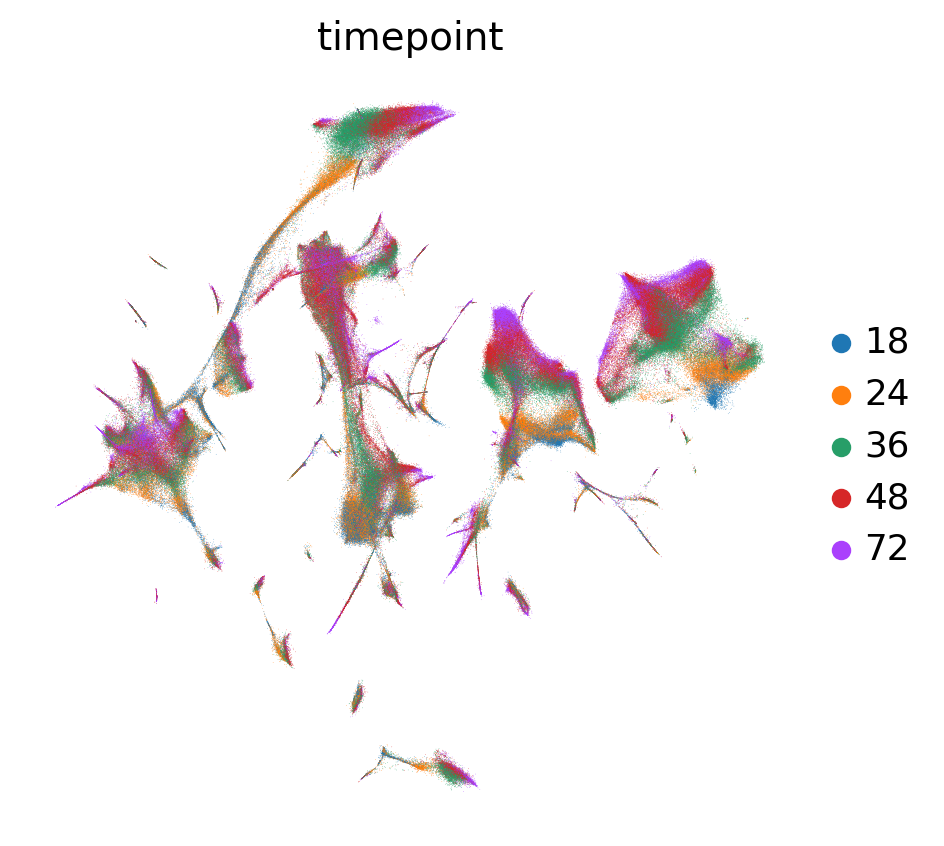

In [28]:
sc.pl.umap(control_cells, color=['timepoint'])

In [29]:
gene_filter = ((zebrafish.obs["gene1"] == "cdx4") & (zebrafish.obs["gene2"] == "cdx1a"))
pertb_cells = zebrafish[gene_filter, :]


/home/icb/alejandro.tejada/miniforge3/envs/data_processing/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alejandro.tejada/miniforge3/envs/data_processing/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


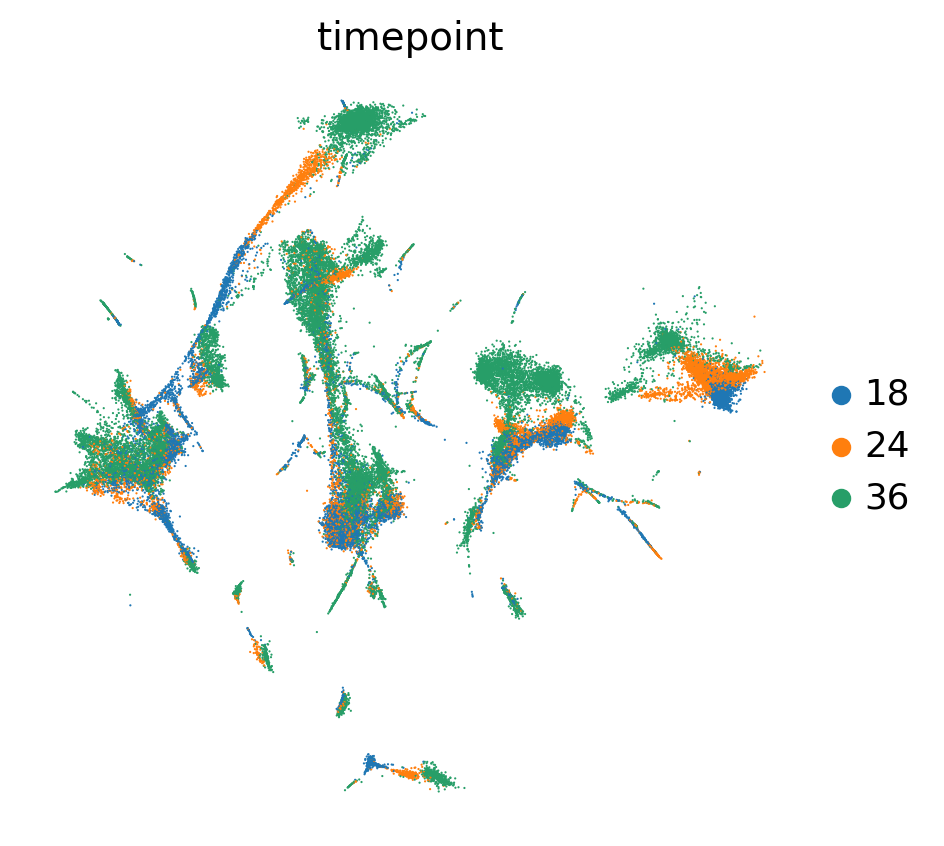

In [30]:
sc.pl.umap(pertb_cells, color=['timepoint'])

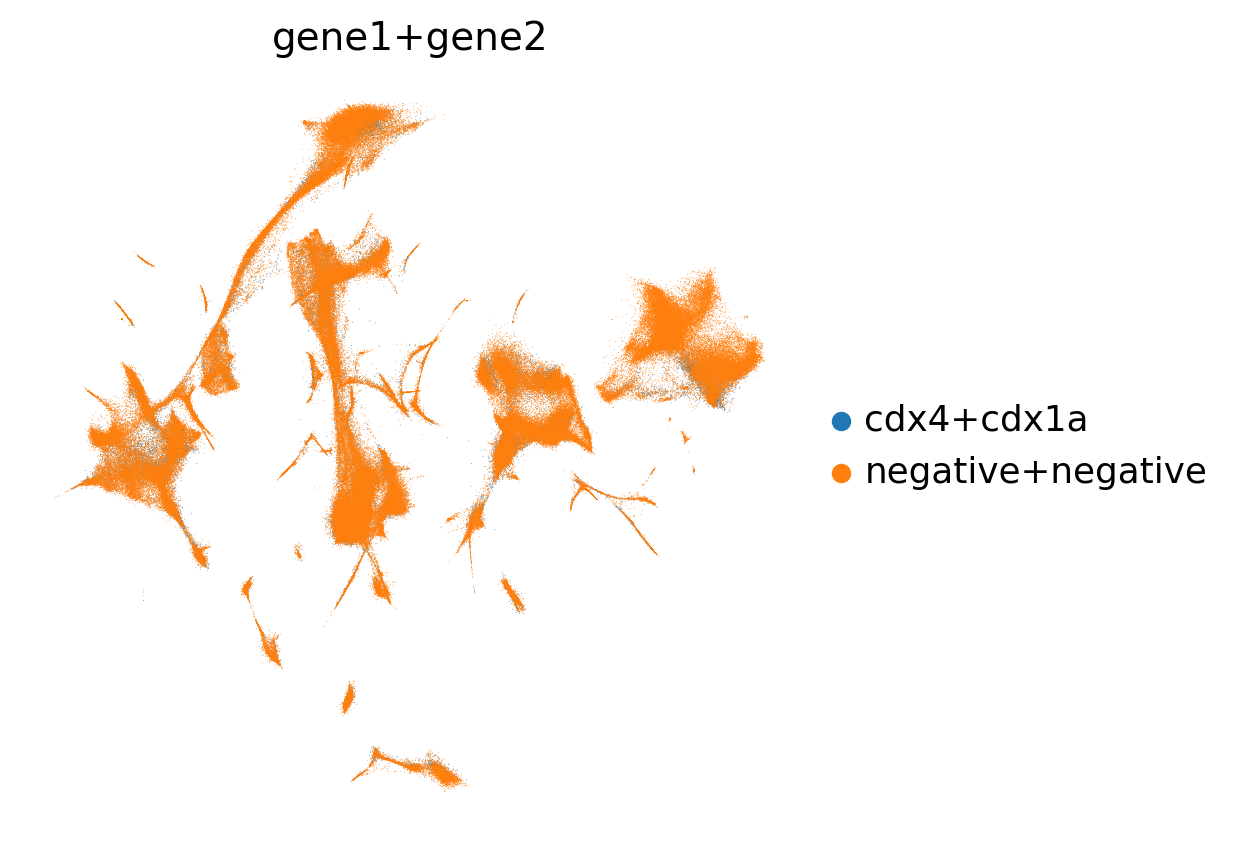

In [31]:
sc.pl.umap(ad.concat([pertb_cells, control_cells[control_cells.obs.timepoint.isin(['18','24','36'])]]), color=['gene1+gene2'])

           

In [32]:
pertb_cells

AnnData object with n_obs × n_vars = 48277 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [33]:
control_cells

AnnData object with n_obs × n_vars = 610839 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [34]:
sc.pp.subsample(control_cells, fraction=0.1)
control_cells

AnnData object with n_obs × n_vars = 61083 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [35]:
zebrafish.obs[['gene1+gene2', 'timepoint']].drop_duplicates()

,gene1+gene2,timepoint
A03_B01_P01-A01_LIG104,negative+negative,18
A03_B01_P01-A02_LIG101,negative+negative,72
A03_B01_P01-A02_LIG127,negative+negative,36
A03_B01_P01-A03_LIG201,negative+negative,48
A03_B01_P01-A07_LIG32,negative+negative,24
...,...,...
A03_B01_P01-C03_LIG152,tbx16+msgn1,18
A03_B01_P01-C06_LIG285,epha4a+negative,18
A03_B01_P01-C11_LIG175,tbxta+negative,18
A03_B01_P01-D01_LIG48,hoxb1a+negative,36


In [36]:
zebrafish.obs[['gene1+gene2', 'timepoint']].value_counts()

gene1+gene2        timepoint
negative+negative  48           204327
                   36           158564
                   72           115985
egr2b+negative     48            86594
negative+negative  24            80761
                                 ...  
tbxta+negative     18            11682
wnt3a+wnt8         18            11185
cdx4+cdx1a         24             9313
tbxta+negative     24             8686
wnt3a+wnt8         24             4738
Name: count, Length: 76, dtype: int64

In [37]:
zebrafish.obs[['gene1+gene2']].drop_duplicates()

,gene1+gene2
A03_B01_P01-A01_LIG104,negative+negative
A03_B01_P01-A01_LIG120,zc4h2+negative
A03_B01_P01-A01_LIG270,met+negative
A03_B01_P01-A01_LIG357,tfap2a+negative
A03_B01_P01-A01_LIG70,hgfa+negative
A03_B01_P01-A02_LIG100,tfap2a+foxd3
A03_B01_P01-A02_LIG126,noto+negative
A03_B01_P01-A02_LIG135,cdx4+cdx1a
A03_B01_P01-A02_LIG150,epha4a+negative
A03_B01_P01-A02_LIG176,mafba+negative


In [38]:
singleton = zebrafish.obs[zebrafish.obs['gene2'] == "negative"]['gene1'].unique()

In [39]:
len(singleton)

19

In [40]:
singleton

array(['negative', 'zc4h2', 'met', 'tfap2a', 'hgfa', 'noto', 'epha4a',
       'mafba', 'smo', 'hand2', 'egr2b', 'cdx4', 'foxi1', 'hoxb1a',
       'tbx16', 'tbx1', 'phox2a', 'foxd3', 'tbxta'], dtype=object)

In [41]:
gene2_comb = zebrafish.obs[zebrafish.obs['gene2'] != "negative"]['gene2'].unique()

In [42]:
len(gene2_comb)

5

In [43]:
gene1_comb = zebrafish.obs[zebrafish.obs['gene2'] != "negative"]['gene1'].unique()

In [44]:
len(gene1_comb)

4

In [45]:
gene_comb = np.concatenate([gene1_comb, gene2_comb])

In [46]:
set(singleton).intersection(set(gene_comb))

{'cdx4', 'foxd3', 'tbx16', 'tfap2a'}

In [47]:
print(f"Genes measured as singleton and also in combination with some other gene are {set(singleton).intersection(set(gene_comb))}")



Genes measured as singleton and also in combination with some other gene are {'cdx4', 'foxd3', 'tfap2a', 'tbx16'}


In [48]:
zebrafish.obs['gene1+gene2'][zebrafish.obs['gene1+gene2'].str.contains('foxd3')].unique()

['tfap2a+foxd3', 'foxd3+negative']
Categories (24, object): ['cdx4+cdx1a', 'cdx4+negative', 'egr2b+negative', 'epha4a+negative', ..., 'tfap2a+foxd3', 'tfap2a+negative', 'wnt3a+wnt8', 'zc4h2+negative']

'tfap2a' and 'foxd3' are combined with each other. We can leave one of them out as an OOD prediction.
Choosing as OOD 'foxd3', we see single 'tfap2a' and 'tfap2a+foxd3`, so its effect could, in theory, still be inferred.

In [49]:
perturbations = set(np.concatenate([zebrafish.obs['gene1'].unique(), zebrafish.obs['gene2'].unique()]))

In [50]:
len(perturbations)

24

In [51]:
perturbations

{'cdx1a',
 'cdx4',
 'egr2b',
 'epha4a',
 'foxd3',
 'foxi1',
 'hand2',
 'hgfa',
 'hoxb1a',
 'mafba',
 'met',
 'msgn1',
 'negative',
 'noto',
 'phox2a',
 'smo',
 'tbx1',
 'tbx16',
 'tbx16l',
 'tbxta',
 'tfap2a',
 'wnt3a',
 'wnt8',
 'zc4h2'}

In general the perturbations are clustered according to their effect:      
- Involved in the development of the **mesoderm** (cdx4, cdx1a, tbxta, tbx16, tbx16l, msgn1, wnt3a, wnt8a, noto, smo, tbx1, hand2)
- Involved in the development of the **central or peripheral nervous system** (egr2b, epha4a, hoxb1a, mafba, zc4h2, phox2a, foxi1, hgfa, met)
- Involved in the development of **neural crest lineages** (foxd3, tfap2a)

- According to the paper, _mafba_ is a perturbation is somehow similar to _egr2b_ and _epha4a_, so it's a candidate for OOD.
- According to the paper, _wnt8a_ is a perturbation is somehow similar to _wnt3a_ and tbxta, so it's a candidate for OOD.
- According to the paper, _smo_ is a perturbation that is not similar to antyhing, so might be candidate for OOD.

In [52]:
zebrafish.obs['is_ood'] = False

In [53]:
zebrafish.obs.loc[zebrafish.obs['gene1+gene2'] == 'smo+negative', 'is_ood'] = True

In [54]:
zebrafish.obs.loc[zebrafish.obs['gene1+gene2'] == 'mafba+negative', 'is_ood'] = True

In [55]:
zebrafish.obs.loc[zebrafish.obs['gene1+gene2'] == 'wnt8a+negative', 'is_ood'] = True

In [56]:
zebrafish.obs.loc[zebrafish.obs['gene1+gene2'] == 'tfap2a+foxd3', 'is_ood'] = True

In [57]:
zebrafish_ood = zebrafish[zebrafish.obs["is_ood"]==True]

In [58]:
zebrafish_ood

View of AnnData object with n_obs × n_vars = 345353 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2', 'is_ood'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [59]:
zebrafish_ood.obs

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,subumap3d_1,subumap3d_2,subumap3d_3,sample,hash_plate,log.hash_umis,gene1+gene2,gene1,gene2,is_ood
A03_B01_P01-A02_LIG100,A03_B01_P01-A02_LIG100,0.499708,227.0,1.321586,72,72h_tfap2a-foxd3_P17_D6,21.0,21.112924,"neurons (gabaergic, glutamatergic)","neurons (gabaergic, glutamatergic)",...,-0.077414,3.839397,3.586615,2,P17,1.322219,tfap2a+foxd3,tfap2a,foxd3,True
A03_B01_P01-A02_LIG176,A03_B01_P01-A02_LIG176,0.578957,263.0,4.562738,36,36h_mafba_P9_C12,7.0,5.022025,"basal cell (fn1b, cyp26a1+; posterior?)",basal cell,...,0.211594,2.243090,0.374565,2,P9,0.845098,mafba+negative,mafba,negative,True
A03_B01_P01-A02_LIG317,A03_B01_P01-A02_LIG317,2.108899,958.0,2.296451,18,18h_smo_P13_A6,103.0,15.089659,"retinal neuron (amacrine, RGC)",retinal neuron,...,-0.490909,2.204427,1.860705,2,P13,2.012837,smo+negative,smo,negative,True
A03_B01_P01-A05_LIG182,A03_B01_P01-A05_LIG182,3.249201,1476.0,5.691057,36,36h_mafba_P9_G12,55.0,8.896100,mature fast muscle 2,mature fast muscle,...,-3.369805,-2.433470,5.129143,2,P9,1.740363,mafba+negative,mafba,negative,True
A03_B01_P01-A05_LIG27,A03_B01_P01-A05_LIG27,0.457882,208.0,10.576923,36,36h_tfap2a-foxd3_P3_G1,12.0,11.161107,intestine (mid),intestine,...,-8.261430,2.332139,-0.254881,2,P3,1.079181,tfap2a+foxd3,tfap2a,foxd3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H07_D12_P04-H09_LIG24,H07_D12_P04-H09_LIG24,0.493104,224.0,1.339286,72,72h_tfap2a-foxd3_P17_E6,63.0,68.764966,"eye, optic cup","eye, optic cup",...,0.495827,-3.347589,-4.280224,2,P17,1.799341,tfap2a+foxd3,tfap2a,foxd3,True
H07_D12_P04-H11_LIG161,H07_D12_P04-H11_LIG161,0.869536,395.0,1.012658,48,48h_mafba_P7_B5,22.0,8.262501,notochord (late),notochord,...,-5.352458,7.791924,-7.302284,2,P7,1.342423,mafba+negative,mafba,negative,True
H07_D12_P04-H11_LIG259,H07_D12_P04-H11_LIG259,1.466103,666.0,22.822823,48,48h_mafba_P7_G5,12.0,8.070360,periderm 16,periderm,...,-1.940065,1.799429,-0.466297,2,P7,1.079181,mafba+negative,mafba,negative,True
H07_D12_P04-H12_LIG258,H07_D12_P04-H12_LIG258,0.911361,414.0,1.932367,24,24h_mafba-mut_P9_A6,99.0,11.482214,neural progenitor (hindbrain R7/8),neural progenitor (hindbrain R7/8),...,1.630804,-5.753800,1.452163,2,P9,1.995635,mafba+negative,mafba,negative,True


In [60]:
zebrafish_train = zebrafish[zebrafish.obs["is_ood"]==False]

In [61]:
zebrafish_train

View of AnnData object with n_obs × n_vars = 2413608 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2', 'is_ood'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [62]:
610839 * 0.15

91625.84999999999

In [63]:
zebrafish_train[zebrafish_train.obs['gene1+gene2']=='negative+negative']

View of AnnData object with n_obs × n_vars = 610839 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2', 'is_ood'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'

In [64]:
# Only change is that, as we have a lot of cells, we sample 15% of them

rng = np.random.default_rng(0)
split_dfs = []
for drug in zebrafish_train.obs["gene1+gene2"].unique():
    zebrafish_subset = zebrafish_train[(zebrafish_train.obs["gene1+gene2"]==drug)]
    n_cells = zebrafish_subset.n_obs
    if drug == "negative+negative":
        idx_test = rng.choice(np.arange(n_cells), math.ceil(n_cells*0.15), replace=False)
        remaining_idcs = set(np.arange(n_cells)) - set(idx_test)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = zebrafish_subset.obs[["gene1+gene2"]].copy()
        df["split"] = split
        split_dfs.append(df)
    elif n_cells>300:
        idx_test = rng.choice(np.arange(n_cells), math.ceil(n_cells*0.15), replace=False)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = zebrafish_subset.obs[["gene1+gene2"]].copy()
        df["split"] = split
        split_dfs.append(df)

In [65]:
df_concat = pd.concat(split_dfs, axis=0)

In [66]:
df_concat

,gene1+gene2,split
A03_B01_P01-A01_LIG104,negative+negative,train
A03_B01_P01-A02_LIG101,negative+negative,train
A03_B01_P01-A02_LIG127,negative+negative,test
A03_B01_P01-A02_LIG257,negative+negative,train
A03_B01_P01-A03_LIG201,negative+negative,train
...,...,...
H07_D12_P04-G03_LIG74,tbxta+negative,train
H07_D12_P04-G05_LIG28,tbxta+negative,train
H07_D12_P04-G08_LIG237,tbxta+negative,train
H07_D12_P04-H05_LIG236,tbxta+negative,test


In [67]:
df_concat[df_concat["gene1+gene2"]=="negative+negative"].split.value_counts()

split
train    519213
test      91626
Name: count, dtype: int64

In [68]:
df_concat["gene1+gene2"].value_counts()

gene1+gene2
negative+negative    610839
egr2b+negative       190132
tfap2a+negative      159388
hgfa+negative        149619
noto+negative        145433
epha4a+negative      124704
foxd3+negative       116702
met+negative          91882
tbx1+negative         87472
foxi1+negative        81688
zc4h2+negative        73288
hand2+negative        72216
hoxb1a+negative       71298
phox2a+negative       71102
tbx16+negative        69279
tbx16+msgn1           60289
tbx16+tbx16l          58023
cdx4+negative         57611
cdx4+cdx1a            48277
tbxta+negative        39680
wnt3a+wnt8            34686
Name: count, dtype: int64

In [69]:
zebrafish_train.obs["split"] = df_concat[["split"]]

/tmp/ipykernel_2798923/2949818696.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  zebrafish_train.obs["split"] = df_concat[["split"]]


In [70]:
zebrafish_train[zebrafish_train.obs.split == 'test'].n_obs

362050

In [71]:
zebrafish_ood.n_obs

345353

In [72]:
zebrafish_train_final = zebrafish_train[zebrafish_train.obs["split"]=="train"]
zebrafish_test_final = zebrafish_train[zebrafish_train.obs["split"]=="test"]
zebrafish_ood_final = ad.concat((zebrafish_ood, zebrafish_test_final[zebrafish_test_final.obs["gene1+gene2"]=="negative+negative"]))



In [73]:
print(f"Train {zebrafish_train_final.n_obs}")
print(f"Test {zebrafish_test_final.n_obs}")
print(f"OOD {zebrafish_ood_final.n_obs}")

Train 2051558
Test 362050
OOD 436979


In [74]:
zebrafish_train_final.varm["X_train_mean"] = zebrafish_train_final.X.mean(axis=0).T

/tmp/ipykernel_2798923/793367313.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  zebrafish_train_final.varm["X_train_mean"] = zebrafish_train_final.X.mean(axis=0).T


In [75]:
from scipy.sparse import csr_matrix, vstack
train_mean = zebrafish_train_final.varm["X_train_mean"].T
zebrafish_train_final.layers["centered_X"] = csr_matrix(zebrafish_train_final.X.A - train_mean)

In [76]:
zebrafish_train_final.obsm["X_pca"] = sc.pp.pca(zebrafish_train_final.layers["centered_X"], zero_center=False, n_comps=50)


In [77]:
zebrafish_train_final

AnnData object with n_obs × n_vars = 2051558 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2', 'is_ood', 'split'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'timepoint_colors', 'log1p', 'hvg'
    obsm: 'X_aligned', 'X_pca', 'X_umap'
    varm: 'X_train_mean'
    layers: 'centered_X'

In [78]:
zebrafish_train_final.obsm["X_pca"].shape

(2051558, 50)

In [79]:
zebrafish_test_final.varm["X_train_mean"] = zebrafish_train_final.varm["X_train_mean"]
zebrafish_ood_final.varm["X_train_mean"] = zebrafish_train_final.varm["X_train_mean"]

/tmp/ipykernel_2798923/2035698924.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  zebrafish_test_final.varm["X_train_mean"] = zebrafish_train_final.varm["X_train_mean"]


In [80]:
zebrafish_test_final.layers["centered_X"] = csr_matrix(zebrafish_test_final.X.A - train_mean)
zebrafish_ood_final.layers["centered_X"] = csr_matrix(zebrafish_ood_final.X.A - train_mean)

In [81]:
zebrafish_test_final.obsm["X_pca"] = np.matmul(zebrafish_test_final.layers["centered_X"].A, zebrafish_train_final.varm["PCs"])
zebrafish_ood_final.obsm["X_pca"] = np.matmul(zebrafish_ood_final.layers["centered_X"].A, zebrafish_train_final.varm["PCs"])


KeyError: 'PCs'

In [ ]:
zebrafish_train_final.varm["X_train_mean"] = np.asarray(zebrafish_train_final.varm["X_train_mean"])
zebrafish_test_final.varm["X_train_mean"] = np.asarray(zebrafish_test_final.varm["X_train_mean"])
zebrafish_ood_final.varm["X_train_mean"] = np.asarray(zebrafish_ood_final.varm["X_train_mean"])

In [ ]:
zebrafish_train_final.write("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_train.h5ad")
zebrafish_test_final.write("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_test.h5ad")
zebrafish_ood_final.write("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_ood.h5ad")

In [ ]:
from sklearn.metrics import r2_score
def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

In [89]:
decoded_test = np.matmul(zebrafish_test_final.obsm["X_pca"], zebrafish_train_final.varm["PCs"].T)

NameError: name 'adata_train_final' is not defined

In [94]:
compute_r_squared(np.asarray(decoded_test+zebrafish_test_final.varm["X_train_mean"].T), zebrafish_test_final.X.A)

0.9996061075877719

In [95]:
decoded_ood = np.matmul(adata_ood_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [96]:
compute_r_squared(np.asarray(decoded_ood+adata_ood_final.varm["X_train_mean"].T), adata_ood_final.X.A)

0.9994916136435403

#### Add embeddings.

In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.sparse import csc_matrix

In [2]:
train = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_train.h5ad")
test = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_test.h5ad")
ood = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_ood.h5ad")

In [3]:
print(ood)
zebrafish_ood_final = ad.concat((ood, test[test.obs["gene1+gene2"]=="negative+negative"]))
print(zebrafish_ood_final)

AnnData object with n_obs × n_vars = 345353 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2', 'is_ood'
    obsm: 'X_aligned', 'X_pca', 'X_umap', 'emb_1', 'emb_2'
    varm: 'X_train_mean'
    layers: 'centered_X'
AnnData object with n_obs × n_vars = 436979 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target',

In [4]:
import glob
import torch

# Specify the folder path
folder_path = '/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/zebra_v2/'

# Use glob to get all .pt files in the folder
pt_files = glob.glob(folder_path + '*.pt')

In [5]:
torch.load(pt_files[0])['mean_representations'][36].shape

torch.Size([2560])

In [6]:
torch.load(pt_files[0])['mean_representations'][36].dtype

torch.float32

In [7]:
len(pt_files)

23

In [8]:
embedding_dim = torch.load(pt_files[0])['mean_representations'][36].shape[0]
embedding_dim

2560

In [9]:
mapping = pd.DataFrame()

In [10]:
train.var

,gene_short_name,id,chromosome,bp1,bp2,gene_strand,num_cells_expressed,highly_variable,means,dispersions,dispersions_norm
ENSDARG00000000212,krt97,ENSDARG00000000212,22,11756040,11759606,+,conf,True,0.045095,1.081777,3.880273
ENSDARG00000000472,cntn2,ENSDARG00000000472,11,23933016,23988182,+,conf,True,0.014969,0.511046,1.581158
ENSDARG00000000503,stx1b,ENSDARG00000000503,19,5157806,5254699,-,conf,True,0.053943,0.496677,1.523275
ENSDARG00000000588,grasp,ENSDARG00000000588,23,32199088,32236122,-,conf,True,0.031881,0.390288,1.094702
ENSDARG00000000767,spi1b,ENSDARG00000000767,7,32644173,32659353,-,conf,True,0.002095,0.593277,1.912416
...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000117645,CR384075.1,ENSDARG00000117645,7,59750111,59868995,+,conf,True,0.081710,0.514946,1.596870
ENSDARG00000117659,CABZ01079280.1,ENSDARG00000117659,KN150127.1,13784,26001,-,conf,True,0.010821,0.688225,2.294903
ENSDARG00000117727,BX510306.1,ENSDARG00000117727,13,26051285,26210369,-,conf,True,0.004780,0.403929,1.149651
ENSDARG00000117747,CABZ01056843.1,ENSDARG00000117747,23,41021511,41155639,+,conf,True,0.124810,0.417410,1.203958


In [11]:
mapping.index = train.var.gene_short_name

In [12]:
train.var.index

Index(['ENSDARG00000000212', 'ENSDARG00000000472', 'ENSDARG00000000503',
       'ENSDARG00000000588', 'ENSDARG00000000767', 'ENSDARG00000001437',
       'ENSDARG00000001463', 'ENSDARG00000001559', 'ENSDARG00000001634',
       'ENSDARG00000001676',
       ...
       'ENSDARG00000117547', 'ENSDARG00000117591', 'ENSDARG00000117603',
       'ENSDARG00000117621', 'ENSDARG00000117622', 'ENSDARG00000117645',
       'ENSDARG00000117659', 'ENSDARG00000117727', 'ENSDARG00000117747',
       'ENSDARG00000117818'],
      dtype='object', length=2000)

In [13]:
mapping['index'] = train.var.index

In [14]:
mapping

,index
gene_short_name,
krt97,ENSDARG00000000212
cntn2,ENSDARG00000000472
stx1b,ENSDARG00000000503
grasp,ENSDARG00000000588
spi1b,ENSDARG00000000767
...,...
CR384075.1,ENSDARG00000117645
CABZ01079280.1,ENSDARG00000117659
BX510306.1,ENSDARG00000117727


In [15]:
mapping.loc['zc4h2'] = 'ENSDARG00000015314'
mapping.loc['tfap2a'] = 'ENSDARG00000059279'
mapping.loc['noto'] = 'ENSDARG00000021201'
mapping.loc['cdx4'] = 'ENSDARG00000036292'
mapping.loc['cdx1a'] = 'ENSDARG00000114554'
mapping.loc['msgn1'] = 'ENSDARG00000070546'
mapping.loc['hand2'] = 'ENSDARG00000008305'
mapping.loc['egr2b'] = 'ENSDARG00000042826'
mapping.loc['foxi1'] = 'ENSDARG00000104566'
mapping.loc['hoxb1a'] = 'ENSDARG00000008174'
mapping.loc['tbx16l'] = 'ENSDARG00000006939'
mapping.loc['tbx1'] = 'ENSDARG00000006939'
mapping.loc['wnt8'] = 'ENSDARG00000078507'
mapping.loc['hgfa'] = 'ENSDARG00000045544'
mapping.loc['foxd3'] = 'ENSDARG00000021032'
mapping.loc['tbxta'] = 'ENSDARG00000101576'
mapping.loc['mafba'] = 'ENSDARG00000017121'
mapping.loc['smo'] = 'ENSDARG00000002952'
mapping.loc['foxd3'] = 'ENSDARG00000021032'

In [16]:
genes_pert = {}

for path in pt_files:
    split_path = path.split('_')
    gene = split_path[4]
    genes_pert[gene] = torch.load(path)['mean_representations'][36].numpy()
    print(torch.load(path)['mean_representations'][36].shape)

torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])
torch.Size([2560])


In [19]:
emb_1_list = []
emb_2_list = []

# Iterate through gene_1 and gene_2 columns
for gene_1, gene_2 in zip(test.obs['gene1'], test.obs['gene2']):

    ensembl_gene_1 = None
    ensembl_gene_2 = None 
    
    if gene_1 != 'negative':
        ensembl_gene_1 = mapping.loc[gene_1]['index']
    if gene_2 != 'negative':
        ensembl_gene_2 = mapping.loc[gene_2]['index']
    
    # Fetch embeddings from embedding_dict
    emb_1 = genes_pert.get(ensembl_gene_1, np.zeros(embedding_dim))
    emb_2 = genes_pert.get(ensembl_gene_2, np.zeros(embedding_dim))
    
    emb_1_list.append(emb_1.astype(np.float32))
    emb_2_list.append(emb_2.astype(np.float32))

emb_1_array = np.array(emb_1_list)
emb_2_array = np.array(emb_2_list)

test.obsm['emb_1'] = csc_matrix(emb_1_array)
test.obsm['emb_2'] = csc_matrix(emb_2_array)



In [20]:
emb_1_list = []
emb_2_list = []

# Iterate through gene_1 and gene_2 columns
for gene_1, gene_2 in zip(train.obs['gene1'], train.obs['gene2']):

    ensembl_gene_1 = None
    ensembl_gene_2 = None 
    
    if gene_1 != 'negative':
        ensembl_gene_1 = mapping.loc[gene_1]['index']
    if gene_2 != 'negative':
        ensembl_gene_2 = mapping.loc[gene_2]['index']
    
    # Fetch embeddings from embedding_dict
    emb_1 = genes_pert.get(ensembl_gene_1, np.zeros(embedding_dim))
    emb_2 = genes_pert.get(ensembl_gene_2, np.zeros(embedding_dim))
    
    emb_1_list.append(emb_1.astype(np.float32))
    emb_2_list.append(emb_2.astype(np.float32))

emb_1_array = np.array(emb_1_list)
emb_2_array = np.array(emb_2_list)

train.obsm['emb_1'] = csc_matrix(emb_1_array)
train.obsm['emb_2'] = csc_matrix(emb_2_array)


In [21]:
emb_1_list = []
emb_2_list = []

# Iterate through gene_1 and gene_2 columns
for gene_1, gene_2 in zip(ood.obs['gene1'], ood.obs['gene2']):

    ensembl_gene_1 = None
    ensembl_gene_2 = None 
    
    if gene_1 != 'negative':
        ensembl_gene_1 = mapping.loc[gene_1]['index']
    if gene_2 != 'negative':
        ensembl_gene_2 = mapping.loc[gene_2]['index']
    
    # Fetch embeddings from embedding_dict
    emb_1 = genes_pert.get(ensembl_gene_1, np.zeros(embedding_dim))
    emb_2 = genes_pert.get(ensembl_gene_2, np.zeros(embedding_dim))
    
    emb_1_list.append(emb_1.astype(np.float32))
    emb_2_list.append(emb_2.astype(np.float32))

emb_1_array = np.array(emb_1_list)
emb_2_array = np.array(emb_2_list)

ood.obsm['emb_1'] = csc_matrix(emb_1_array)
ood.obsm['emb_2'] = csc_matrix(emb_2_array)

In [26]:
ood.obs

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,subumap3d_1,subumap3d_2,subumap3d_3,sample,hash_plate,log.hash_umis,gene1+gene2,gene1,gene2,is_ood
A03_B01_P01-A02_LIG100,A03_B01_P01-A02_LIG100,0.499708,227.0,1.321586,72,72h_tfap2a-foxd3_P17_D6,21.0,21.112924,"neurons (gabaergic, glutamatergic)","neurons (gabaergic, glutamatergic)",...,-0.077414,3.839397,3.586615,2,P17,1.322219,tfap2a+foxd3,tfap2a,foxd3,True
A03_B01_P01-A02_LIG176,A03_B01_P01-A02_LIG176,0.578957,263.0,4.562738,36,36h_mafba_P9_C12,7.0,5.022025,"basal cell (fn1b, cyp26a1+; posterior?)",basal cell,...,0.211594,2.243090,0.374565,2,P9,0.845098,mafba+negative,mafba,negative,True
A03_B01_P01-A02_LIG317,A03_B01_P01-A02_LIG317,2.108899,958.0,2.296451,18,18h_smo_P13_A6,103.0,15.089659,"retinal neuron (amacrine, RGC)",retinal neuron,...,-0.490909,2.204427,1.860705,2,P13,2.012837,smo+negative,smo,negative,True
A03_B01_P01-A05_LIG182,A03_B01_P01-A05_LIG182,3.249201,1476.0,5.691057,36,36h_mafba_P9_G12,55.0,8.896100,mature fast muscle 2,mature fast muscle,...,-3.369805,-2.433470,5.129143,2,P9,1.740363,mafba+negative,mafba,negative,True
A03_B01_P01-A05_LIG27,A03_B01_P01-A05_LIG27,0.457882,208.0,10.576923,36,36h_tfap2a-foxd3_P3_G1,12.0,11.161107,intestine (mid),intestine,...,-8.261430,2.332139,-0.254881,2,P3,1.079181,tfap2a+foxd3,tfap2a,foxd3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H07_D12_P04-H09_LIG24,H07_D12_P04-H09_LIG24,0.493104,224.0,1.339286,72,72h_tfap2a-foxd3_P17_E6,63.0,68.764966,"eye, optic cup","eye, optic cup",...,0.495827,-3.347589,-4.280224,2,P17,1.799341,tfap2a+foxd3,tfap2a,foxd3,True
H07_D12_P04-H11_LIG161,H07_D12_P04-H11_LIG161,0.869536,395.0,1.012658,48,48h_mafba_P7_B5,22.0,8.262501,notochord (late),notochord,...,-5.352458,7.791924,-7.302284,2,P7,1.342423,mafba+negative,mafba,negative,True
H07_D12_P04-H11_LIG259,H07_D12_P04-H11_LIG259,1.466103,666.0,22.822823,48,48h_mafba_P7_G5,12.0,8.070360,periderm 16,periderm,...,-1.940065,1.799429,-0.466297,2,P7,1.079181,mafba+negative,mafba,negative,True
H07_D12_P04-H12_LIG258,H07_D12_P04-H12_LIG258,0.911361,414.0,1.932367,24,24h_mafba-mut_P9_A6,99.0,11.482214,neural progenitor (hindbrain R7/8),neural progenitor (hindbrain R7/8),...,1.630804,-5.753800,1.452163,2,P9,1.995635,mafba+negative,mafba,negative,True


In [29]:
train.write("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_train.h5ad")
test.write("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_test.h5ad")
ood.write("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_ood.h5ad")

### Get embeddings dictionary

In [82]:
import os
import pickle

In [2]:
train = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_train.h5ad")
test = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_test.h5ad")
ood = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/adata_ood.h5ad")

In [3]:
train

AnnData object with n_obs × n_vars = 2051558 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2', 'is_ood', 'split'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'hvg', 'log1p', 'pca', 'timepoint_colors'
    obsm: 'X_aligned', 'X_pca', 'X_umap', 'emb_1', 'emb_2'
    varm: 'PCs', 'X_train_mean'
    layers: 'centered_X'

In [4]:
gene_1 = train.obs['gene1']
gene_2 = train.obs['gene2']

# Extract the emb_gene_1 and emb_gene_2 arrays from obsm
emb_gene_1 = train.obsm['emb_1']
emb_gene_2 = train.obsm['emb_2']

# Initialize an empty dictionary to store the gene embeddings
gene_dict = {}

# Iterate over the rows and populate the dictionary
for idx, (g1, g2) in enumerate(zip(gene_1, gene_2)):
    if g1 not in gene_dict:
        gene_dict[g1] = emb_gene_1[idx]
    if g2 not in gene_dict:
        gene_dict[g2] = emb_gene_2[idx]


In [5]:
len(gene_dict)

22

In [6]:
gene_1 = ood.obs['gene1']
gene_2 = ood.obs['gene2']

# Extract the emb_gene_1 and emb_gene_2 arrays from obsm
emb_gene_1 = ood.obsm['emb_1']
emb_gene_2 = ood.obsm['emb_2']

# Iterate over the rows and populate the dictionary
for idx, (g1, g2) in enumerate(zip(gene_1, gene_2)):
    if g1 not in gene_dict:
        gene_dict[g1] = emb_gene_1[idx]
    if g2 not in gene_dict:
        gene_dict[g2] = emb_gene_2[idx]


In [7]:
len(gene_dict)

24

Add time as it is also a condition.

In [91]:
for tp in train.obs.timepoint.unique():
    base = np.ones_like(gene_dict['negative'])
    base = np.log(int(tp)) * base
    gene_dict[tp] = base

In [92]:
gene_dict

{'negative': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'zc4h2': array([-0.02506289, -0.07073252, -0.0024553 , ...,  0.11043672,
        -0.09344348, -0.04177243], dtype=float32),
 'tfap2a': array([-0.00381041, -0.04080139,  0.06805582, ..., -0.01037988,
        -0.1381323 ,  0.03878225], dtype=float32),
 'noto': array([ 0.05363961,  0.01176855,  0.05549588, ..., -0.04774645,
        -0.10090527,  0.04875639], dtype=float32),
 'cdx4': array([ 0.04544561,  0.0085295 ,  0.02384006, ..., -0.00804145,
        -0.16306993,  0.0667288 ], dtype=float32),
 'cdx1a': array([ 0.04072264, -0.00771822,  0.00958598, ..., -0.00357641,
        -0.17223947,  0.07910734], dtype=float32),
 'epha4a': array([ 0.01345224,  0.00413656, -0.04197775, ...,  0.01749663,
        -0.10178802, -0.02238981], dtype=float32),
 'tbx16': array([ 0.02869553,  0.029533  ,  0.03738478, ...,  0.02877543,
        -0.15769206,  0.00988513], dtype=float32),
 'msgn1': array([ 0.04363045, -0.05146808,  0.04632477, ...

In [93]:
with open(os.path.join("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish/ESM2_embeddings.pkl"), 'wb') as file:
    pickle.dump(gene_dict, file)

In [94]:
dict_int_to_embedding = gene_dict

In [95]:
ind_to_cond = {i: k for i, k in enumerate(dict_int_to_embedding.keys())}
cond_to_ind = {k: i for i, k in ind_to_cond.items()}
ind_to_emb = {cond_to_ind.get(k, -1): v for k, v in dict_int_to_embedding.items()}
def map_emb(x):
    return cond_to_ind.get(x, -1)
vectorized_map_emb = np.vectorize(map_emb)


In [97]:
train.obsm['cond_gene1'] = np.expand_dims(train.obs['gene1'], axis=1)
train.obsm['cond_gene2'] = np.expand_dims(train.obs['gene2'], axis=1)
train.obsm['cond_time'] = np.expand_dims(train.obs['timepoint'], axis=1)

indices1 = vectorized_map_emb(train.obsm['cond_gene1'])
indices2 = vectorized_map_emb(train.obsm['cond_gene2'])
indices3 = vectorized_map_emb(train.obsm['cond_time'])

In [98]:
indices3

array([[24],
       [25],
       [24],
       ...,
       [26],
       [26],
       [25]])

In [99]:
train

AnnData object with n_obs × n_vars = 2051558 × 2000
    obs: 'cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis', 'timepoint', 'Oligo', 'hash_umis', 'top_to_second_best_ratio', 'cell_type_sub', 'cell_type_broad', 'tissue', 'germ_layer', 'log.n.umi', 'num_genes_expressed', 'umap3d_1', 'umap3d_2', 'umap3d_3', 'all_clust', 'major_group', 'group_cluster', 'gene_target', 'mean_nn_time', 'subumap3d_1', 'subumap3d_2', 'subumap3d_3', 'sample', 'hash_plate', 'log.hash_umis', 'gene1+gene2', 'gene1', 'gene2', 'is_ood', 'split'
    var: 'gene_short_name', 'id', 'chromosome', 'bp1', 'bp2', 'gene_strand', 'num_cells_expressed', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_target_colors', 'hvg', 'log1p', 'pca', 'timepoint_colors'
    obsm: 'X_aligned', 'X_pca', 'X_umap', 'emb_1', 'emb_2', 'cond_gene1', 'cond_gene2', 'cond_time'
    varm: 'PCs', 'X_train_mean'
    layers: 'centered_X'